# In the first part I cleaned data by replacing 0s as well as removing outliers.
# In the second part I developed models using Logistic Regression, Support Vector Machine(SVM) and Random Forest. Meanwhile I compared model scores based on column 'insulin_test' dropped with replaced.
# The Random Forst with 'insulin_test' replaced yielded the highest AUC and accuracy score, so the prediction result was generated using this model.

In [1]:
import pandas as pd

df = pd.read_csv(r'C:\Users\zhang\Downloads\recruiting_zeta-disease_training-data_take-home-challenge - 2021_zeta-disease_training-data_take-home-challenge.csv')

In [2]:
df.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [3]:
## First to see the data quality
## Looks like no null value.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
age                   800 non-null int64
weight                800 non-null int64
bmi                   800 non-null float64
blood_pressure        800 non-null int64
insulin_test          800 non-null int64
liver_stress_test     800 non-null float64
cardio_stress_test    800 non-null int64
years_smoking         800 non-null int64
zeta_disease          800 non-null int64
dtypes: float64(2), int64(7)
memory usage: 56.3 KB
None


In [4]:
# Take a glance at the variable distribution
# min(bmi) = 0, insulin_test.quantile(0.25) = 0 and cardio_stress_test.quantile(0.25) = 0.
print(df.describe())

              age      weight         bmi  blood_pressure  insulin_test  \
count  800.000000  800.000000  800.000000      800.000000    800.000000   
mean    30.985000  172.407500   32.201625       69.565000     85.887500   
std     13.824025   31.942438    8.549155       19.874784    126.333656   
min     18.000000   94.000000    0.000000        0.000000      0.000000   
25%     21.000000  149.000000   27.300000       62.000000      0.000000   
50%     26.000000  167.000000   32.050000       72.000000     45.000000   
75%     38.000000  192.000000   36.525000       80.000000    130.000000   
max    109.000000  308.000000   86.100000      157.000000   1077.000000   

       liver_stress_test  cardio_stress_test  years_smoking  zeta_disease  
count         800.000000          800.000000     800.000000    800.000000  
mean            0.544496           43.121250       4.051250      0.348750  
std             0.348711           30.409949       4.176173      0.476873  
min             0.14

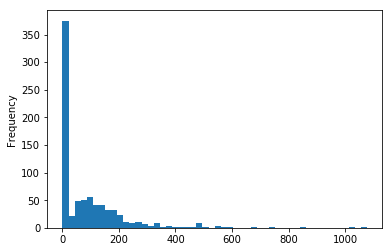

In [79]:
df['insulin_test'].plot.hist(alpha = 1, bins = 50)

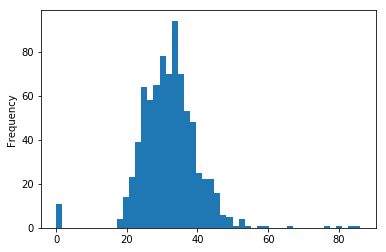

In [6]:
df['bmi'].plot.hist(alpha = 1, bins = 50)

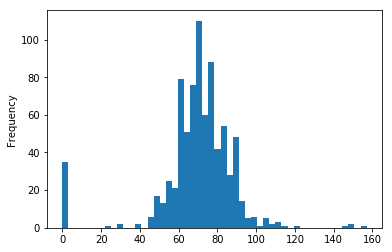

In [7]:
df['blood_pressure'].plot.hist(alpha = 1, bins = 50)

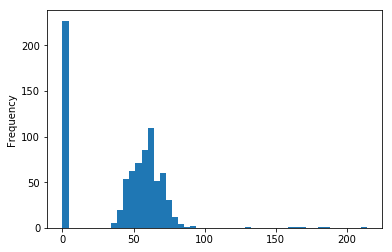

In [8]:
df['cardio_stress_test'].plot.hist(alpha = 1, bins = 50)

In [9]:
# Start with 'insulin_test'.
# Tried to see if there is linearity among these features. The R square is ~0.24, so that's a no.

from sklearn.linear_model import LinearRegression

df_it = df[df['insulin_test'] != 0]

model = LinearRegression()
model.fit(df_it[['age','bmi','weight','blood_pressure','liver_stress_test','cardio_stress_test','years_smoking']], df_it['insulin_test'])
model.score(df_it[['age','bmi','weight','blood_pressure','liver_stress_test','cardio_stress_test','years_smoking']], df_it['insulin_test'])

0.2386606110166143

## 'insulin_test' has over 350 0s out of 800, and the std is 126.33, so it is not a good idea to replace 0s with mean/median/mode. So I decided to do it in two ways: 1. drop 'insulin_test' and 2. fill 'insulin_test' using mice method. Then compare models to determine which is better.
## 'bmi', 'blood_pressure' and 'cardio_stress_test' have some 0s but they are neither widely distributed nor skewed. So replacing 0s with mean is what I chose for them.

In [10]:
# Now I will try to drop it and develop model without 'insulin_test'.

df.drop(['insulin_test'], axis = 1, inplace = True)

In [11]:
bmi_mean = round(df['bmi'][df['bmi'] != 0].mean(),1)
blood_pressure_mean = round(df['blood_pressure'][df['blood_pressure'] != 0].mean(),1)
cardio_stress_test_mean = round(df['cardio_stress_test'][df['cardio_stress_test'] != 0].mean(),1)

In [12]:
df['bmi'].replace(0, bmi_mean, inplace=True)
df['blood_pressure'].replace(0, blood_pressure_mean, inplace=True)
df['cardio_stress_test'].replace(0, cardio_stress_test_mean, inplace=True)

In [13]:
# Much better.
# 'age' got max = 109...How could a 109-year old person migrate to Mars? So I decided to further clean the data.
print(df.describe())

              age      weight         bmi  blood_pressure  liver_stress_test  \
count  800.000000  800.000000  800.000000      800.000000         800.000000   
mean    30.985000  172.407500   32.651250       72.745625           0.544496   
std     13.824025   31.942438    7.655927       13.165281           0.348711   
min     18.000000   94.000000   18.200000       24.000000           0.140800   
25%     21.000000  149.000000   27.500000       64.000000           0.307800   
50%     26.000000  167.000000   32.400000       72.000000           0.445300   
75%     38.000000  192.000000   36.525000       80.000000           0.699800   
max    109.000000  308.000000   86.100000      157.000000           3.481300   

       cardio_stress_test  years_smoking  zeta_disease  
count          800.000000     800.000000    800.000000  
mean            60.203000       4.051250      0.348750  
std             13.682302       4.176173      0.476873  
min             37.000000       0.000000      0.000

In [14]:
# To clean data using interquantile range.
# Given the sample size is not big, I used 3*iqr to keep these mild outliers.
for c in df.columns:
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3-q1
    df = df[(df[c]>q1-3*iqr) & (df[c]<q3+3*iqr)]

In [15]:
# Much better. 'age' = 78 is still an impressive number, but there are alwasy some brave old people.Old soldiers never die.
# There used to be two cases whose years_smoking > age. Dude started smoking even before being born, lol. Luckily they got 'cleaned'.
# Now min(df['age']- df['years_smoking']) = 11. I personally know someone started smoking at 11, so I decided to keep.
print(df.describe())

              age      weight         bmi  blood_pressure  liver_stress_test  \
count  761.000000  761.000000  761.000000      761.000000         761.000000   
mean    30.174770  171.981603   32.287779       72.273982           0.525655   
std     11.762438   31.643278    6.636634       12.022130           0.300716   
min     18.000000   94.000000   18.200000       24.000000           0.140800   
25%     21.000000  149.000000   27.500000       64.000000           0.306800   
50%     26.000000  167.000000   32.400000       72.000000           0.438800   
75%     38.000000  191.000000   36.300000       80.000000           0.688800   
max     78.000000  308.000000   57.300000      122.000000           1.843800   

       cardio_stress_test  years_smoking  zeta_disease  
count          761.000000     761.000000    761.000000  
mean            59.088568       3.875164      0.342970  
std              8.107819       3.365291      0.475014  
min             37.000000       0.000000      0.000

In [16]:
# See how many people of these 761 got zeta disease. If one category is way more than the other, we need to deal with imbalanced data.
# It turns out that the data is ok, so no need to worry about imbalanced data.
df.groupby('zeta_disease').size()

zeta_disease
0    500
1    261
dtype: int64

In [17]:
# Independent variables
x = df.iloc[:,0:-1]
# Dependent variables
y = df.iloc[:,-1:]

### VIF cutoff = 10. I did not write while loop to autimatically remove any feature with VIF >= 10.
### It is because 'age' has an intial VIF of 12.14 while it is an important factor in disease prediction. I need to keep an eye on it.
### So I did it manually, removing one feature per time, since there are not many features. 
### 'weight', 'bmi' and 'blood_pressure' are positively associated. 

In [18]:
# To check multicollinearity, using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['attribute'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, x.columns.get_loc(i)) for i in x.columns]
print(vif)

            attribute        VIF
0                 age  12.144533
1              weight  29.228124
2                 bmi  37.433107
3      blood_pressure  37.788434
4   liver_stress_test   4.086427
5  cardio_stress_test  54.749868
6       years_smoking   3.293091


In [19]:
# cardio_stress_test got a too high VIF, so drop it and calculate VIF again.
x.drop(['cardio_stress_test'], axis = 1, inplace  = True)

In [20]:
vif = pd.DataFrame()
vif['attribute'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, x.columns.get_loc(i)) for i in x.columns]
print(vif)

           attribute        VIF
0                age  12.065844
1             weight  26.891571
2                bmi  25.067410
3     blood_pressure  33.717819
4  liver_stress_test   4.082126
5      years_smoking   3.293002


In [21]:
# blood_pressure got a too high VIF, so drop it and calculate VIF again.
x.drop(['blood_pressure'], axis = 1, inplace = True)

In [22]:
vif = pd.DataFrame()
vif['attribute'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, x.columns.get_loc(i)) for i in x.columns]
print(vif)

           attribute        VIF
0                age  10.799400
1             weight  22.639298
2                bmi  18.335033
3  liver_stress_test   4.080291
4      years_smoking   3.292997


In [23]:
# Weight got a too high VIF, so drop it and calculate VIF again.
x.drop(['weight'], axis = 1, inplace = True)

In [24]:
vif = pd.DataFrame()
vif['attribute'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, x.columns.get_loc(i)) for i in x.columns]
print(vif)

           attribute       VIF
0                age  9.157546
1                bmi  8.081578
2  liver_stress_test  3.950349
3      years_smoking  3.285327


### The data without 'insulin_test' is prepared, now start Logistic Regression

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 15)

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear')
lr.fit(x_train, y_train.values.ravel())

print('Logistic Regression accuracy score is:',lr.score(x_test, y_test))

Logistic Regression accuracy score is: 0.6950819672131148


In [27]:
lr_y_pred = lr.predict(x_test)

In [28]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(y_test, lr_y_pred)
roc_auc = auc(fpr,tpr)
print('Logistic Regression AUC is:',roc_auc)

Logistic Regression AUC is: 0.6032047027590784


### Start SVM

In [29]:
from sklearn import svm

svm_model = svm.SVC(kernel='linear',gamma=1,random_state = 15) 
svm_model.fit(x_train, y_train.values.ravel())

print('SVM accuracy score is:',svm_model.score(x_test, y_test))

SVM accuracy score is: 0.6983606557377049


In [30]:
svm_y_pred =  svm_model.predict(x_test)

In [31]:
fpr, tpr, _ = roc_curve(y_test, svm_y_pred)
roc_auc = auc(fpr,tpr)
print('SVM AUC is:',roc_auc)

SVM AUC is: 0.5991040106191334


### Start Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier #use RandomForestRegressor for regression problem

rf_model = RandomForestClassifier(n_estimators=100,random_state = 15)
rf_model.fit(x_train, y_train.values.ravel())

print('Random Forest accuracy score is:',rf_model.score(x_test, y_test))

Random Forest accuracy score is: 0.6754098360655738


In [33]:
rf_y_pred = rf_model.predict(x_test)

In [34]:
fpr, tpr, _ = roc_curve(y_test, rf_y_pred)
roc_auc = auc(fpr,tpr)
print('Random Forest AUC is:',roc_auc)

Random Forest AUC is: 0.6167867640087229


# In case of 'insulin_test' dropped, Random Forest has the highes AUC.
## Now tried to replace 0s of 'insulin_test' using mice.

In [60]:
df = pd.read_csv(r'C:\Users\zhang\Downloads\recruiting_zeta-disease_training-data_take-home-challenge - 2021_zeta-disease_training-data_take-home-challenge.csv')

In [36]:
bmi_mean = round(df['bmi'][df['bmi'] != 0].mean(),1)
blood_pressure_mean = round(df['blood_pressure'][df['blood_pressure'] != 0].mean(),1)
cardio_stress_test_mean = round(df['cardio_stress_test'][df['cardio_stress_test'] != 0].mean(),1)

In [37]:
df['bmi'].replace(0, bmi_mean, inplace=True)
df['blood_pressure'].replace(0, blood_pressure_mean, inplace=True)
df['cardio_stress_test'].replace(0, cardio_stress_test_mean, inplace=True)

In [38]:
for c in df.columns:
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3-q1
    df = df[(df[c]>q1-3*iqr) & (df[c]<q3+3*iqr)]

In [39]:
import numpy as np
from impyute.imputation.cs import mice

df['insulin_test'].replace(0, np.nan, inplace=True)
imputed_training = mice(df.values)
df_w_insulin = pd.DataFrame(imputed_training, columns = df.columns)

In [40]:
# Independent variables
x = df_w_insulin.iloc[:,0:-1]
# Dependent variables
y = df_w_insulin.iloc[:,-1:]

In [41]:
vif = pd.DataFrame()
vif['attribute'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, x.columns.get_loc(i)) for i in x.columns]
print(vif)

            attribute        VIF
0                 age  12.362698
1              weight  40.750111
2                 bmi  39.943912
3      blood_pressure  39.354881
4        insulin_test   7.191359
5   liver_stress_test   4.072337
6  cardio_stress_test  57.583060
7       years_smoking   3.324081


In [42]:
# cardio_stress_test got a too high VIF, so drop it and calculate VIF again.
x.drop(['cardio_stress_test'], axis = 1, inplace = True)

C:\Users\zhang\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [43]:
vif = pd.DataFrame()
vif['attribute'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, x.columns.get_loc(i)) for i in x.columns]
print(vif)

           attribute        VIF
0                age  12.243295
1             weight  35.847818
2                bmi  25.514605
3     blood_pressure  36.376821
4       insulin_test   6.848636
5  liver_stress_test   4.068693
6      years_smoking   3.324074


In [44]:
# blood_pressure got a too high VIF, so drop it and calculate VIF again.
x.drop(['blood_pressure'], axis = 1, inplace = True)

In [45]:
vif = pd.DataFrame()
vif['attribute'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, x.columns.get_loc(i)) for i in x.columns]
print(vif)

           attribute        VIF
0                age  10.828817
1             weight  28.023982
2                bmi  18.363169
3       insulin_test   6.413857
4  liver_stress_test   4.068272
5      years_smoking   3.322744


In [46]:
# weight got a too high VIF, so drop it and calculate VIF again.
x.drop(['weight'], axis = 1, inplace = True)

In [47]:
# bmi is ok, so I kept it.

vif = pd.DataFrame()
vif['attribute'] = x.columns
vif['VIF'] = [variance_inflation_factor(x.values, x.columns.get_loc(i)) for i in x.columns]
print(vif)

           attribute        VIF
0                age   9.567147
1                bmi  10.250305
2       insulin_test   5.137819
3  liver_stress_test   3.953698
4      years_smoking   3.320366


In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 15)

In [49]:
lr_i = LogisticRegression(solver='liblinear')
lr_i.fit(x_train, y_train.values.ravel())

print('Logistic Regression accuracy score is:',lr_i.score(x_test, y_test))

Logistic Regression accuracy score is: 0.7906976744186046


In [50]:
lr_y_pred = lr_i.predict(x_test)

fpr, tpr, _ = roc_curve(y_test, lr_y_pred)
roc_auc = auc(fpr,tpr)
print('Logistic Regression AUC is:',roc_auc)

Logistic Regression AUC is: 0.7229674170007194


In [51]:
svm_model_i = svm.SVC(kernel='linear',gamma=1,random_state = 15) 
svm_model_i.fit(x_train, y_train.values.ravel())

print('SVM accuracy score is:',svm_model_i.score(x_test, y_test))

SVM accuracy score is: 0.7807308970099668


In [52]:
svm_y_pred =  svm_model_i.predict(x_test)

fpr, tpr, _ = roc_curve(y_test, svm_y_pred)
roc_auc = auc(fpr,tpr)
print('SVM AUC is:',roc_auc)

SVM AUC is: 0.7128173501901531


In [53]:
rf_model_i = RandomForestClassifier(n_estimators=100,random_state = 15)
rf_model_i.fit(x_train, y_train.values.ravel())

print('Random Forest accuracy score is:',rf_model_i.score(x_test, y_test))

Random Forest accuracy score is: 0.7774086378737541


In [54]:
rf_y_pred = rf_model_i.predict(x_test)

fpr, tpr, _ = roc_curve(y_test, rf_y_pred)
roc_auc = auc(fpr,tpr)
print('Random Forest AUC is:',roc_auc)

Random Forest AUC is: 0.7568609312365094


### Random Forest with 'insulin_test' filled has the highes AUC as well as accuracy score, so I will go with RF.

In [55]:
df_pred = pd.read_csv(r'C:\Users\zhang\Downloads\recruiting_zeta-disease_prediction-data_take-home-challenge - 2021-01-21_zeta-disease_prediction-data_take-home-challenge.csv')

In [56]:
df_pred.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,NaN
1,27,179,35.5,89,156,1.6608,43,6,NaN
2,34,147,26.9,76,74,1.6958,53,2,NaN
3,35,206,32.4,73,127,1.4608,61,6,NaN
4,60,193,29.8,62,192,1.7798,65,9,NaN


In [57]:
x_pred = df_pred[['age','insulin_test','liver_stress_test','cardio_stress_test','years_smoking']]

In [58]:
df_pred['zeta_disease'] = rf_model_i.predict(x_pred).astype(int)

In [59]:
df_pred

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,1
1,27,179,35.5,89,156,1.6608,43,6,0
2,34,147,26.9,76,74,1.6958,53,2,0
3,35,206,32.4,73,127,1.4608,61,6,0
4,60,193,29.8,62,192,1.7798,65,9,0
5,45,120,36.5,108,50,1.2978,54,12,0
6,20,139,38.2,61,77,1.5818,68,3,0
7,23,137,31.2,70,73,1.4168,59,7,1
8,36,195,30.5,59,141,1.4498,59,6,0
9,19,193,25.8,84,66,1.7938,50,3,0


In [78]:
df['age'].is_unique

False